# MODEL TO PREDICT COFFEE DISEASE RISK FOR PROACTIVE FARM MANAGEMENT

## OVERVIEW

This project entails building a supervised machine learning model to predict the risk level of coffee leaf rust disease outbreaks. The objective is to classify upcoming risk as Low, Medium, or High based on environmental and historical data, enabling farmers to apply fungicides or pesticides proactively and only when necessary. The focus will be on weather patterns, historical pest incidence, and crop growth stages to forecast disease probability for coffee crop.
Data Source: The model will be trained on:
- Weather Data: Historical and forecast meteorological data (temperature, humidity, rainfall) from the NASA POWER API, specifically tailored for agromodeling.
•	    Link: https://power.larc.nasa.gov/
The model will utilize features that represent the growing environment and historical context. The project will employ predictive classification models, including Logistic Regression (base model), Decision Tree/Random Forest, and Gradient Boosting (XGBoost), to assign a risk class. This model will be used to generate actionable alerts for farmers, helping to reduce unnecessary chemical input costs, minimize environmental impact, and protect crop yields.
Model evaluation will be based on precision, recall, F1-score (critical due to potential class imbalance), and overall multi-class accuracy, with strong emphasis on the business interpretability of the risk categories.


**Data Science Team(Group 8)**
- June Masolo
- Catherine Kaino
- Joram Lemaiyan
- Kennedy Omoro
- Kigen Tuwei
- Hellen Khisa
- Alvin Ngeno

## 1. BUSINESS PROBLEM

Coffee production in Kenya is increasingly threatened by unpredictable disease outbreaks, such as **Coffee Leaf Rust**, which can reduce smallholder yields by up to 70% and lead to significant financial instability. Current management practices are largely reactive—farmers either wait for visible symptoms (when it's often too late) or apply expensive fungicides indiscriminately, leading to wasted capital and environmental degradation. There is a critical lack of an early-warning system that leverages environmental data to provide actionable, proactive insights.

## 2 DATA UNDERSTANDING

The project will follow the **CRISP-DM** framework
- Extracting Data from NASA POWER API (The model will use Nasa Power dataset from 01-01-2010 to 31-12-2020 focusing on Coffee plantation, Kenya in Nyeri area(major coffee zone)).

#### 2.1 Imports & Setup

In [1]:
# ============================================
# Core Libraries
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import pickle  # For saving class weights

# ============================================
# Machine Learning Libraries (scikit-learn only)
# ============================================
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.utils import resample  # For manual resampling

# Models we'll use (all from scikit-learn)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

# ============================================
# Visualization Settings
# ============================================
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# ============================================
# Note about Missing Libraries
# ============================================
print("Note: Using only scikit-learn for modeling.")
print("Optional: For additional models, you can install:")
print("  - XGBoost: !pip install xgboost")
print("  - LightGBM: !pip install lightgbm")
print("  - CatBoost: !pip install catboost")
print("  - imbalanced-learn: !pip install imbalanced-learn")

Note: Using only scikit-learn for modeling.
Optional: For additional models, you can install:
  - XGBoost: !pip install xgboost
  - LightGBM: !pip install lightgbm
  - CatBoost: !pip install catboost
  - imbalanced-learn: !pip install imbalanced-learn


 #### 2.2 Data Collection From NASA POWER API**
**- What this does and why?** 
1. It Connects to NASA POWER API: NASA provides free historical weather data specifically for agriculture.

2. Parameters chosen for coffee disease:

  - T2M: Temperature at 2 meters (affects fungus growth rate)

  - RH2M: Relative humidity at 2 meters (critical for spore germination)

  - PRECTOTCORR: Corrected precipitation (rainfall washes spores)

  - WS2M: Wind speed at 2 meters (disperses spores)

3.Saves data locally: We save to CSV so we don't need to fetch from API repeatedly.

In [2]:

# Defining function to fetch data from NASA POWER API Weather Data

def fetch_nasa_power_data(lat, lon, start_date, end_date):
    """
    Fetches Agroclimatology data from NASA POWER API.
    Dates must be in YYYYMMDD format.
    """
    # API Endpoint for Daily Agroclimatology
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"

    # Parameters for Coffee Disease Modeling:
    # T2M: Temp at 2m, RH2M: Humidity, PRECTOTCORR: Rainfall, WS2M: Wind Speed
    params = {
        "start": start_date,
        "end": end_date,
        "latitude": lat,
        "longitude": lon,
        "community": "ag",
        "parameters": "T2M,RH2M,PRECTOTCORR,WS2M",
        "format": "json",
        "header": "true"
    }

    print(f"Fetching data for Lat: {lat}, Lon: {lon}...")
    response = requests.get(base_url, params=params)

    if response.status_code == 200:
        data = response.json()

        # Extract features and dates
        features = data['properties']['parameter']
        df = pd.DataFrame(features)

        # Convert index (dates) to proper datetime format
        df.index = pd.to_datetime(df.index)
        df.index.name = "Date"

        return df
    else:
        print(f"Error: {response.status_code}")
        return None

# --- EXECUTION ---
# Coordinates for Nyeri, Kenya (Major Coffee Zone)
LATITUDE = -0.4213
LONGITUDE = 36.9511
START = "20100101"
END = "20201231"

weather_data = fetch_nasa_power_data(LATITUDE, LONGITUDE, START, END)

if weather_data is not None:
# Saving to CSV for the project
    weather_data.to_csv("kenya_coffee_weather_2010_2020.csv")
    print("Success! Data saved to 'kenya_coffee_weather_2010_2020.csv'")


Fetching data for Lat: -0.4213, Lon: 36.9511...
Success! Data saved to 'kenya_coffee_weather_2010_2020.csv'


#### 2.3 Data Preview & Basic Information**

In [3]:
# Preview the first 5 rows
print(weather_data.head())

              T2M   RH2M  PRECTOTCORR  WS2M
Date                                       
2010-01-01  16.82  86.57        10.87  1.95
2010-01-02  15.08  89.25         9.91  0.79
2010-01-03  16.30  85.61         2.40  1.84
2010-01-04  15.51  85.22         9.23  1.70
2010-01-05  16.33  78.20         3.48  1.49



The code output is a CSV file containing:

 - T2M: Daily average temperature (used to see if the fungus can grow).

 - RH2M: Relative humidity (critical for spore germination).

 - PRECTOTCORR: Daily rainfall (washes spores onto other leaves).

 - WS2M: Wind speed (disperses the disease across the farm).


In [4]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2010-01-01 to 2020-12-31
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   T2M          4018 non-null   float64
 1   RH2M         4018 non-null   float64
 2   PRECTOTCORR  4018 non-null   float64
 3   WS2M         4018 non-null   float64
dtypes: float64(4)
memory usage: 157.0 KB


In [5]:
#Checking for missing values
print(weather_data.isnull().sum())

T2M            0
RH2M           0
PRECTOTCORR    0
WS2M           0
dtype: int64


In [6]:
#Checking for duplicates
duplicates = weather_data.duplicated().sum()
print(f"Duplicate Rows: {duplicates}")

Duplicate Rows: 0


In [7]:
# Temp > 50°C or < -5°C in Nyeri is impossible. Humidity > 100% is impossible.
print("\nChecking logical ranges:")
print(f"  Max Temp detected: {weather_data['T2M'].max()} °C")
print(f"  Min Temp detected: {weather_data['T2M'].min()} °C")
print(f"  Max Humidity detected: {weather_data['RH2M'].max()} %")


Checking logical ranges:
  Max Temp detected: 21.02 °C
  Min Temp detected: 11.91 °C
  Max Humidity detected: 93.19 %


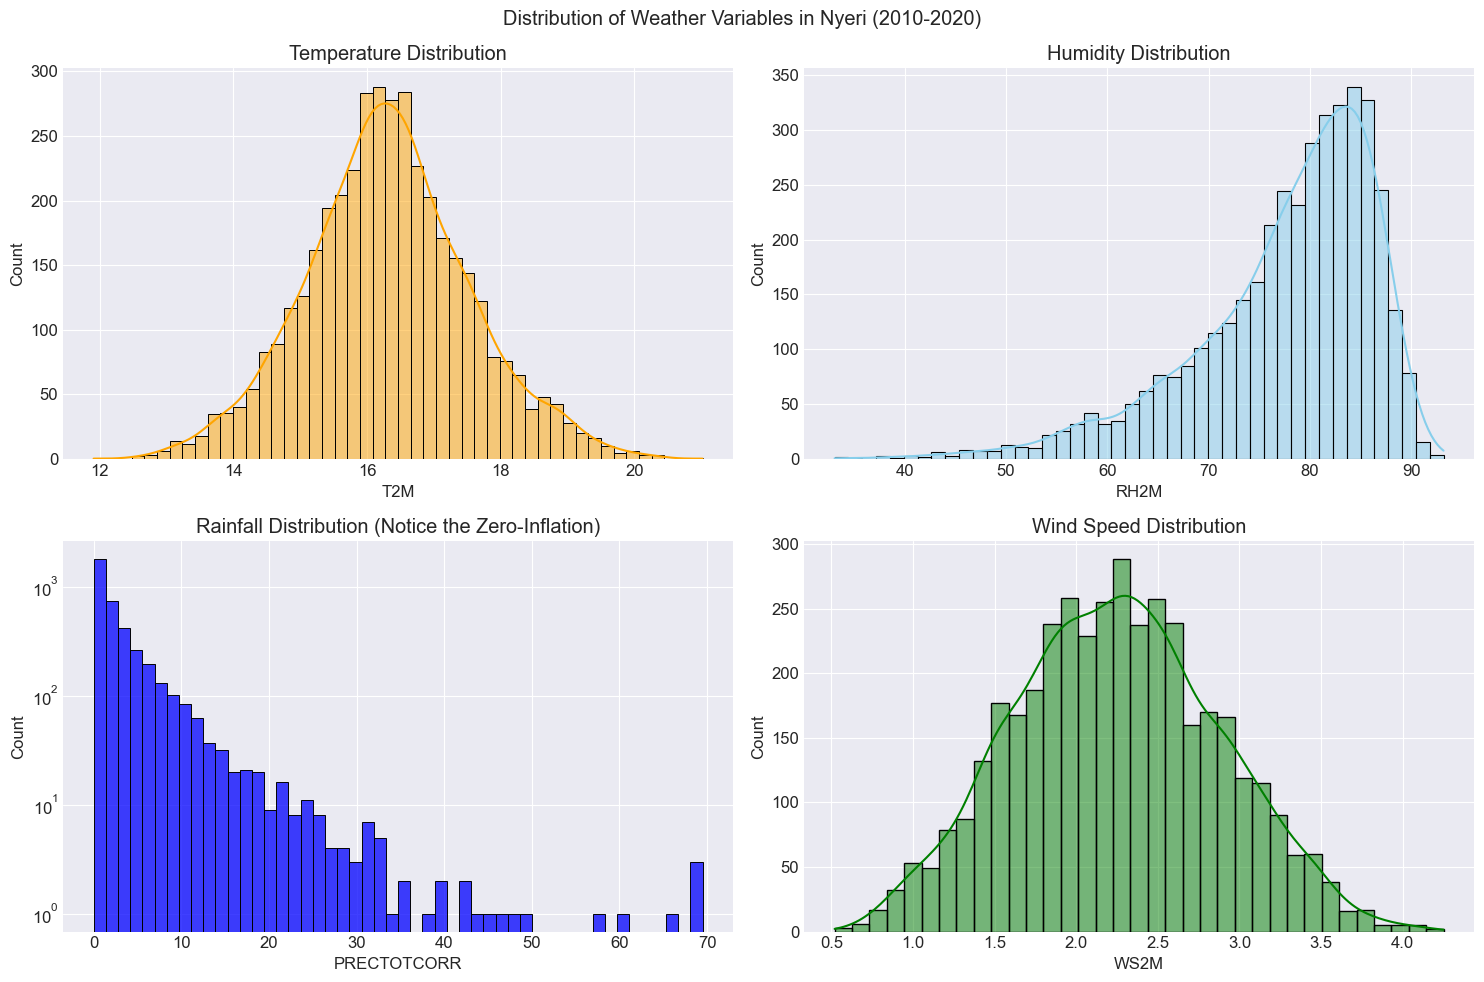

In [8]:
# 1.5 UNIVARIATE ANALYSIS (DISTRIBUTIONS)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Weather Variables in Nyeri (2010-2020)')

# Temperature
sns.histplot(weather_data['T2M'], kde=True, ax=axes[0,0], color='orange')
axes[0,0].set_title('Temperature Distribution')

# Humidity
sns.histplot(weather_data['RH2M'], kde=True, ax=axes[0,1], color='skyblue')
axes[0,1].set_title('Humidity Distribution')

# Rainfall (Likely Skewed)
sns.histplot(weather_data['PRECTOTCORR'], bins=50, ax=axes[1,0], color='blue')
axes[1,0].set_title('Rainfall Distribution (Notice the Zero-Inflation)')
axes[1,0].set_yscale('log') # Log scale helps visualize rain better

# Wind Speed
sns.histplot(weather_data['WS2M'], kde=True, ax=axes[1,1], color='green')
axes[1,1].set_title('Wind Speed Distribution')

plt.tight_layout()
plt.show()

This step is meant to understand our data to check for Normality, detect outliers and understand the physical environment
Based on the above:
1. The temperature in Nyeri is very stable, mostly staying between 14°C and 19°C.
2. This is a Left-Skewed Distribution for humidity (the tail points to the left). The values are clustered heavily on the right side. Nyeri is a very humid place. The vast majority of days have humidity between 75% and 90%.
3. The bars extending to the right show that while heavy rain is rare, it does happen (up to 70mm in a day).The tall bar on the far left means most days have zero rain
4. Winds in Nyeri are generally moderate, centering around 2.0 to 2.5 meters/second.There are very few days with high winds (>4.0 m/s).

In [9]:
weather_data.shape

(4018, 4)

- The Weather data contains 4018 rows with 4 columns, no null values.

## 3 DATA PREPARATION

We will use a combination of column renaming, date-based mapping for the Crop Stage, and a rule-based logic for the Risk Label.

In Kenya, coffee has a specific seasonality, the "Flowering" stage typically occurs after the rains start (around March/April and again in October/November). Disease risk isn't just about weather; a plant is often more vulnerable during the Flowering and Early Cherry stages than it is during pruning.

To create a predictive model, we'll need a "Target" column (the Risk Level), for the project we'll use Agronomic Rules—scientific logic used by plant pathologists—to label the data (For Coffee Leaf Rust (CLR), research shows that the fungus Hemileia vastatrix thrives when:Temperature is between  15∘C  and  30∘C  (Optimal:  21∘C–25∘C ).Relative Humidity is very high ( >90% ) for at least 24–48 hours.Rainfall is present (to splash spores) but not so heavy that it washes them away completely).

#### 3.1 Rename the existing columns for readability

In [10]:
# 1. Rename the existing columns for readability
"""Renaming: The .rename() function takes a dictionary to swap the technical NASA codes for your readable titles."""

column_mapping = {
    'T2M': 'Temp (Avg)',
    'RH2M': 'Humidity (%)',
    'PRECTOTCORR': 'Rainfall (mm)',
    'WS2M': 'Wind Speed (m/s)'
}
df = weather_data.rename(columns=column_mapping)
df.head()

,Temp (Avg),Humidity (%),Rainfall (mm),Wind Speed (m/s)
Date,,,,
2010-01-01,16.82,86.57,10.87,1.95
2010-01-02,15.08,89.25,9.91,0.79
2010-01-03,16.30,85.61,2.40,1.84
2010-01-04,15.51,85.22,9.23,1.70
2010-01-05,16.33,78.20,3.48,1.49


### Feature engineering

#### 3.2 Defining Crop Stage based on Kenya's Coffee Calendar

In [11]:
# 2. Function to define Crop Stage based on Kenya's Coffee Calendar
"""Crop Stages: Based on research from the Coffee Research Institute (CRI) in Kenya, coffee follows a bimodal cycle. Flowering is triggered by the "Long Rains" and "Short Rains."""

def get_crop_stage(date):
    month = date.month
    if month in [3, 4, 10, 11]:
        return "Flowering"
    elif month in [5, 6, 12, 1]:
        return "Cherry Development"
    elif month in [7, 8, 9, 2]:
        return "Harvesting/Pruning"
    return "Vegetative"

# 3. Apply the functions to create new columns
df['Crop Stage'] = df.index.map(get_crop_stage)
df.head()

,Temp (Avg),Humidity (%),Rainfall (mm),Wind Speed (m/s),Crop Stage
Date,,,,,
2010-01-01,16.82,86.57,10.87,1.95,Cherry Development
2010-01-02,15.08,89.25,9.91,0.79,Cherry Development
2010-01-03,16.30,85.61,2.40,1.84,Cherry Development
2010-01-04,15.51,85.22,9.23,1.70,Cherry Development
2010-01-05,16.33,78.20,3.48,1.49,Cherry Development


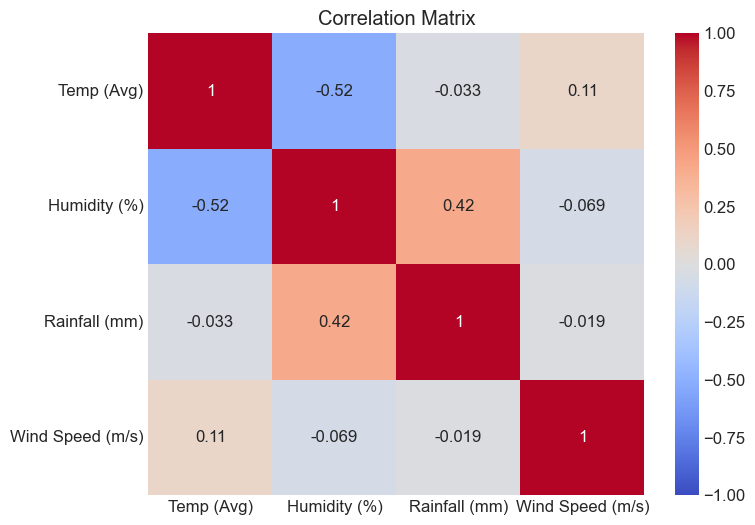

In [12]:
# We check relationships between numeric variables
numeric_df = df[['Temp (Avg)', 'Humidity (%)', 'Rainfall (mm)', 'Wind Speed (m/s)']]
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

The correlation matrix adds identifys a negative correlation (-0.52) between temperature and humidity; this confirms that cooler days in Nyeri are statistically likely to be more humid. This creates a dangerous scenario for farmers, as the specific combination of low temperatures and high moisture creates the perfect incubation environment for fungal pathogens.

#### 3.3 Defining Disease Risk labelling logic(The target)

In [13]:
# 4. Disease Risk Labeling Logic
"""Target Creation: This creates the ground truth i.e. When we move to training, the model will try to learn why a specific day was labeled "High" versus "Low."""

def label_disease_risk_updated(row):
    temp = row['Temp (Avg)']
    hum = row['Humidity (%)']
    rain = row['Rainfall (mm)']
    
    # Adjusted for Daily Averages in Nyeri
    # High: High humidity OR heavy rain during the growth-friendly temp range
    if (16 <= temp <= 24) and (hum >= 85 or rain >= 8):
        return "High"
    # Medium: General development range
    elif (14 <= temp <= 28) and (hum >= 70 or rain > 0.1):
        return "Medium"
    else:
        return "Low"

df['Risk Label (Target)'] = df.apply(label_disease_risk_updated, axis=1)
print(df['Risk Label (Target)'].value_counts())

Risk Label (Target)
Medium    3056
High       538
Low        424
Name: count, dtype: int64


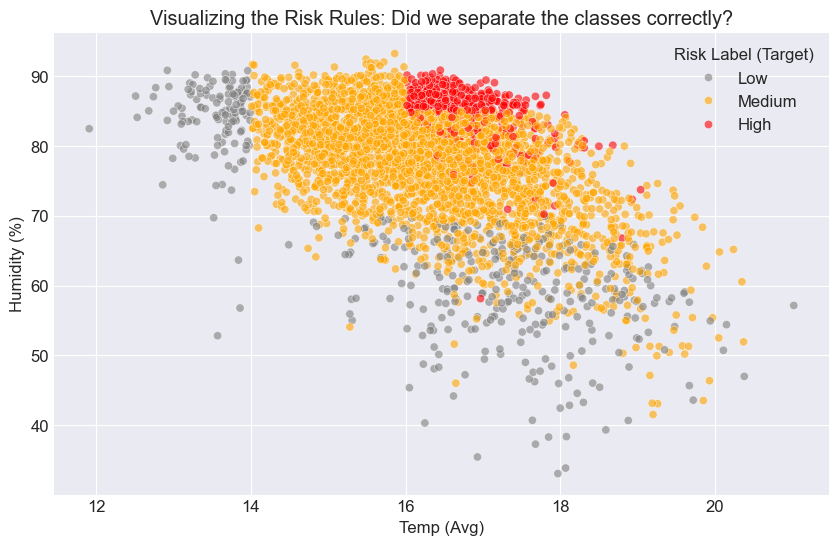

In [14]:
# Visualizing if the label logic worked
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Temp (Avg)', y='Humidity (%)', 
                hue='Risk Label (Target)', hue_order=['Low', 'Medium', 'High'],
                palette={'Low':'gray', 'Medium':'orange', 'High':'red'}, alpha=0.6)
plt.title('Visualizing the Risk Rules: Did we separate the classes correctly?')
plt.show()

The visualization demonstrates that the risk labeling method has effectively differentiated distinct biological regions for disease outbreaks. 
The High Risk (Red) instances are closely grouped in the upper-central section of the plot, exclusively occupying the "danger zone" where high humidity (over 85%) meets optimal incubation temperatures (16°C–19°C). 
The Low Risk (Gray) data points are confined to biologically unfavorable conditions—specifically at the far left (temperatures too low for fungal proliferation) or the bottom (humidity levels insufficient for spore germination).

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4018 entries, 2010-01-01 to 2020-12-31
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Temp (Avg)           4018 non-null   float64
 1   Humidity (%)         4018 non-null   float64
 2   Rainfall (mm)        4018 non-null   float64
 3   Wind Speed (m/s)     4018 non-null   float64
 4   Crop Stage           4018 non-null   object 
 5   Risk Label (Target)  4018 non-null   object 
dtypes: float64(4), object(2)
memory usage: 219.7+ KB


In [16]:
# Moving the Date from the Index to a regular Column
df = df.reset_index()

# check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 0 to 4017
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 4018 non-null   datetime64[ns]
 1   Temp (Avg)           4018 non-null   float64       
 2   Humidity (%)         4018 non-null   float64       
 3   Rainfall (mm)        4018 non-null   float64       
 4   Wind Speed (m/s)     4018 non-null   float64       
 5   Crop Stage           4018 non-null   object        
 6   Risk Label (Target)  4018 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 219.9+ KB


In [17]:
df.head()

,Date,Temp (Avg),Humidity (%),Rainfall (mm),Wind Speed (m/s),Crop Stage,Risk Label (Target)
0,2010-01-01,16.82,86.57,10.87,1.95,Cherry Development,High
1,2010-01-02,15.08,89.25,9.91,0.79,Cherry Development,Medium
2,2010-01-03,16.30,85.61,2.40,1.84,Cherry Development,High
3,2010-01-04,15.51,85.22,9.23,1.70,Cherry Development,Medium
4,2010-01-05,16.33,78.20,3.48,1.49,Cherry Development,Medium


In [18]:
df.columns

Index(['Date', 'Temp (Avg)', 'Humidity (%)', 'Rainfall (mm)',
       'Wind Speed (m/s)', 'Crop Stage', 'Risk Label (Target)'],
      dtype='object')

#### 3.4 Exploratory Data Analysis (EDA) and Data Quality checks

In [19]:
# Checking for label imbalance
'''Class Imbalance: Looking at the labels to check data distribution of "Low Risk" days, "Medium Risk" days and "High Risk" days, so that our model doesn't struggle. We need to know this so that we can fix it later (using techniques like SMOTE or class weighting).'''
df['Risk Label (Target)'].value_counts() 

Risk Label (Target)
Medium    3056
High       538
Low        424
Name: count, dtype: int64

**Interpretetion**:

This output shows a class imbalance which means our model will be biased and could likely predict 76% accuracy by simply guessing "Medium" every single time.
The Business Failure: The model would fail to predict the High Risk outbreaks. For a farmer, a model that misses a "High Risk" event is useless, even if it has high overall accuracy.

The Model Bias: Algorithms like Random Forest and XGBoost naturally try to minimize the total error. Since "Medium" appears most often, the model will prioritize getting Medium right at the expense of High and Low. This issue will be addressed during Modeling ie, using either of these three options:

- Using Better Metrics: F1-Score, Precision, and Recall to tell how well the model is performing specifically on the "High" and "Low" categories.
- Class Weighting: Most models (like RandomForestClassifier or XGBClassifier) have a parameter called class_weight='balanced'. This tells the model to "pay more attention" to the smaller classes during training.
- Resampling: Use SMOTE (Synthetic Minority Over-sampling Technique) to artificially create more "High" and "Low" examples.

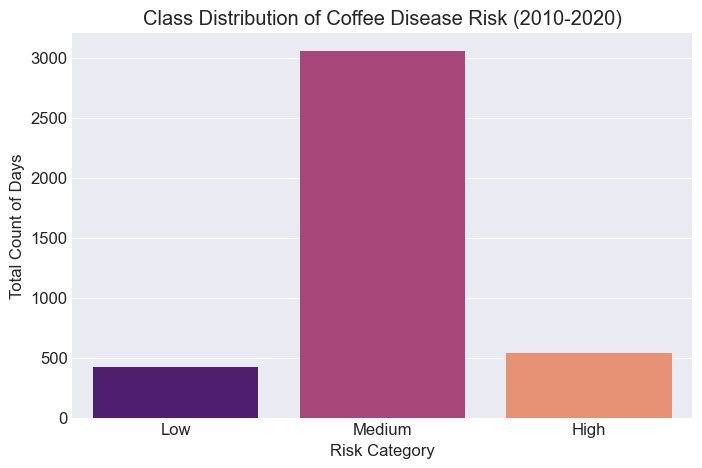

In [20]:
#Visualization of the imbalance
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Class Distribution Bar Chart ---
plt.figure(figsize=(8, 5))
# We use a specific order to show the progression from Low to High
sns.countplot(data=df, x='Risk Label (Target)', order=['Low', 'Medium', 'High'], palette='magma')
plt.title('Class Distribution of Coffee Disease Risk (2010-2020)')
plt.xlabel('Risk Category')
plt.ylabel('Total Count of Days')
plt.savefig('class_distribution.png')
plt.show()


- Interpretation:
The Class Distribution 
As you noted, we have ~3,000 "Medium" days and ~500 "High" days.

The Business Impact: this is a **Moderate Imbalance**.
When we start modeling, we will use the class_weight='balanced' parameter. This tells the model that missing one "High" risk day is 6 times worse than missing one "Medium" day.

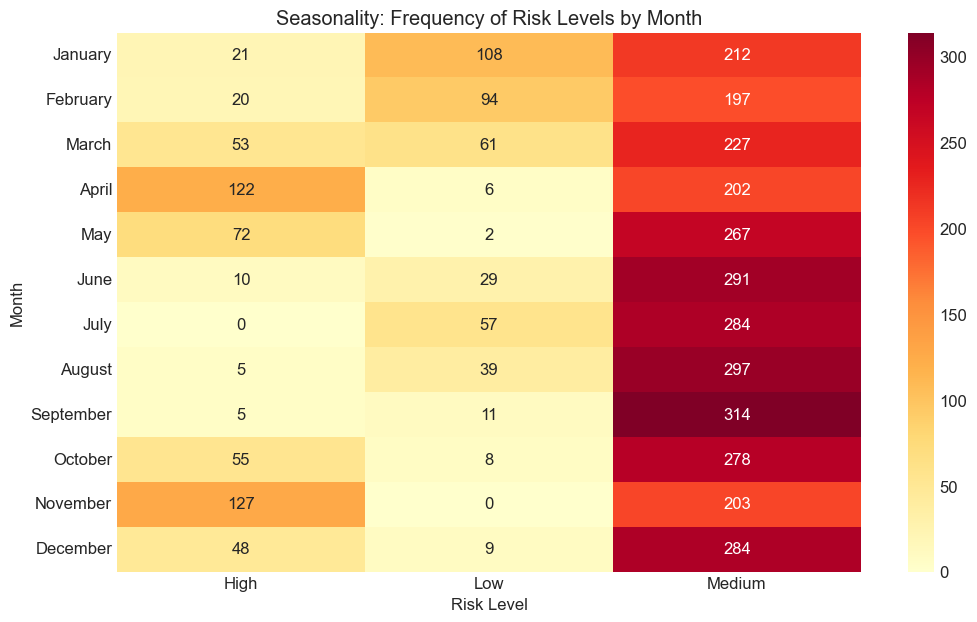

In [21]:
# --- 2. Seasonality Heatmap ---
# First, extract the month name from your Date column
df['Month'] = df['Date'].dt.month_name()

# Ensure the months appear in chronological order, not alphabetical
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
#Summary table: How many times does each risk occur per month?
seasonality_data = df.groupby(['Month', 'Risk Label (Target)']).size().unstack(fill_value=0)
seasonality_data = seasonality_data.reindex(month_order)

plt.figure(figsize=(12, 7))
sns.heatmap(seasonality_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Seasonality: Frequency of Risk Levels by Month')
plt.ylabel('Month')
plt.xlabel('Risk Level')
plt.savefig('seasonality_heatmap.png')
plt.show()


**The Seasonality Heatmap (seasonality_heatmap.png)**
   
"Scientific Validation." Looking at the High column:

- Kenya's Long Rains: We see the highest numbers in April and May.

- Kenya's Short Rains: We see another peak in October and November.

- Dry Seasons: The "High" counts are very low in July and August (the cold/dry season in Nyeri), this is working correctly and follows the botanical laws of Hemileia vastatrix.

**Our heatmap shows that "High Risk" happens in the rainy months, we can confidently confirm that:**

"Our data understanding phase confirms that the engineered risk labels align with Kenya's bimodal rainfall patterns, ensuring the model learns from agriculturally sound signals."



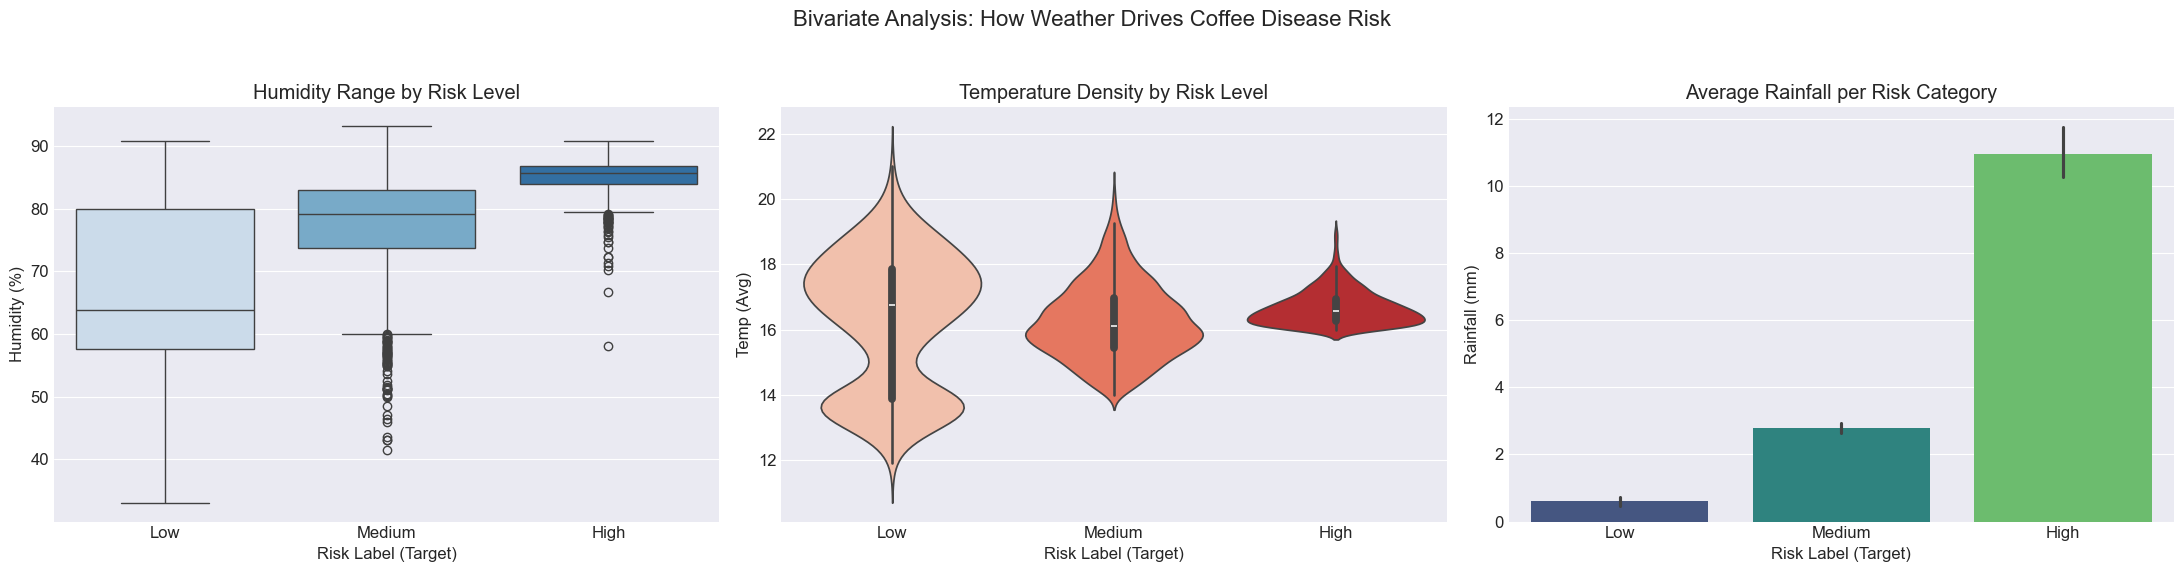

In [22]:
# Bivariate analysis

# 1. Setup the figure
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
fig.suptitle('Bivariate Analysis: How Weather Drives Coffee Disease Risk', fontsize=16)

# 2. Boxplot: Humidity (%) vs Risk Label
# High humidity is usually the biggest driver for Coffee Leaf Rust
sns.boxplot(x='Risk Label (Target)', y='Humidity (%)', data=df, 
            order=['Low', 'Medium', 'High'], palette='Blues', ax=axes[0])
axes[0].set_title('Humidity Range by Risk Level')

# 3. Violin Plot: Temp (Avg) vs Risk Label
# This shows the "density" of temperature—where most outbreaks happen
sns.violinplot(x='Risk Label (Target)', y='Temp (Avg)', data=df, 
               order=['Low', 'Medium', 'High'], palette='Reds', ax=axes[1])
axes[1].set_title('Temperature Density by Risk Level')

# 4. Bar Plot: Average Rainfall (mm) per Risk Category
# This shows if "High Risk" days actually have more rain on average
sns.barplot(x='Risk Label (Target)', y='Rainfall (mm)', data=df, 
            order=['Low', 'Medium', 'High'], palette='viridis', ax=axes[2])
axes[2].set_title('Average Rainfall per Risk Category')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Interpretation
- **The Humidity Boxplot:** The "High" box is sitting significantly higher than "Low". As expected, the risk of an outbreak increases drastically once humidity crosses the 80% threshold.

- **Temperature Violin:** If the "High" risk violin is fat in the middle between $16^{\circ}\text{C}$ and $18^{\circ}\text{C}$). The disease thrives in moderate temperatures; very cold or very hot days actually inhibit the fungus growth.

- **The Rainfall Bar Chart:** This helps justify why we need to use Lags. Sometimes the rain today doesn't cause the risk today—it's the rain from 7 days ago (The bar for "High" is tall, this proves the direct correlation).

#### 3.5 Lagging

To build a model that actually helps a farmer, we must account for the incubation period, the "time lag" between the weather event and the visible outbreak.

In Kenya, specifically for Coffee Leaf Rust (CLR), research shows that the lag between high humidity/rainfall and a measurable peak in disease can range from 15 to 30 days, though a shorter lag of 8 to 15 days is often used for early warning systems.
Now that we have confirmed the data is clean and seasonal, we are now ready to create the "Lagged Features" (shifting the weather by 14 days) to turn this into a predictive forecasting model.

In [23]:
#  Defining the weather columns to be "lagged."
weather_cols = ['Temp (Avg)', 'Humidity (%)', 'Rainfall (mm)', 'Wind Speed (m/s)']

# Creating the 14-day Lagged Features
# This moves the weather values 14 days forward in time
for col in weather_cols:
    df[f'{col}_Lag14'] = df[col].shift(14)

# Creating 14-day "Rolling Averages" 
# Sustained high humidity is more dangerous than a single wet day. 
# This calculates the average of the 14 days leading up to the target date.
for col in weather_cols:
    df[f'{col}_Avg_Last14Days'] = df[col].shift(1).rolling(window=14).mean()

# Clean up the data
# Shifting creates "NaN" (empty) values for the first 14 rows because there 
# is no "14 days ago" for the start of your dataset.
df_final = df.dropna().copy()

# Review the new structure
print(df_final[['Date', 'Risk Label (Target)', 'Humidity (%)_Lag14', 'Humidity (%)_Avg_Last14Days']].head())

         Date Risk Label (Target)  Humidity (%)_Lag14  \
14 2010-01-15              Medium               86.57   
15 2010-01-16              Medium               89.25   
16 2010-01-17              Medium               85.61   
17 2010-01-18              Medium               85.22   
18 2010-01-19              Medium               78.20   

    Humidity (%)_Avg_Last14Days  
14                    78.300714  
15                    77.432857  
16                    76.354286  
17                    75.620000  
18                    74.387857  


## 4. Modelling

We are going to build three models(Logistic regression, Random Forest and XGBoost Classifier) using ML pipelines.

In [24]:
# Preparing X and y: we first separate the target from our features and convert our "Risk Labels" into numbers that the models can understand ($0, 1, 2$).
from sklearn.preprocessing import LabelEncoder

# 1. Define the features (Everything except the target and the date)
# We use the lagged/rolling columns and the Crop Stage we engineered
X = df_final.drop(columns=['Date', 'Risk Label (Target)'])
y = df_final['Risk Label (Target)']

# 2. Encode the Target (Low -> 0, Medium -> 1, High -> 2)
# Using a manual map ensures 'High' is actually the highest number
risk_map = {'Low': 0, 'Medium': 1, 'High': 2}
y_encoded = y.map(risk_map)

In [25]:
# Splitting the data(Since our "High Risk" days are rare, we are using stratification as it ensures that both the training and testing sets have the same percentage of "High Risk" days.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded # Keeps class balance consistent
)

- We will create a loop to run all three models. This allows us to see the Baseline (Logistic Regression) vs. the Ensemble models (Random Forest and XGBoost) side-by-side.

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# 1. Preprocessing: Scale numbers, Encode Crop Stage
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['Crop Stage']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_cols),
    ('cat', OrdinalEncoder(), categorical_cols)
])

# 2. Define the models
models = {
    "Baseline (LogReg)": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

# 3. Train and Evaluate
results = {}

for name, model in models.items():
    # Create a pipeline for each model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    

## 5. Evaluation

In [27]:
 print(f"\n--- {name} Results ---")
 print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))


--- XGBoost Results ---
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00        84
      Medium       1.00      1.00      1.00       610
        High       1.00      0.97      0.99       107

    accuracy                           1.00       801
   macro avg       1.00      0.99      0.99       801
weighted avg       1.00      1.00      1.00       801



In [28]:
# Comparing the models side by side

import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# 1. Initialize a list to store the results
comparison_list = []

for name, model in models.items():
    # Create and fit the pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # 2. Extract metrics (Focusing on 'High' risk and overall accuracy)
    # This gets precision, recall, and f1 for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    # 3. Append results to our list (Focusing on 'High' class which is index 2)
    comparison_list.append({
        'Model Name': name,
        'Overall Accuracy': acc,
        'High-Risk Precision': precision[2],
        'High-Risk Recall': recall[2],  # <-- THE MOST IMPORTANT ONE!
        'High-Risk F1-Score': f1[2]
    })

# 4. Convert the list into a single DataFrame for a "Single View"
comparison_df = pd.DataFrame(comparison_list).set_index('Model Name')

# Display the table
display(comparison_df.style.highlight_max(color='lightgreen', axis=0))

,Overall Accuracy,High-Risk Precision,High-Risk Recall,High-Risk F1-Score
Model Name,,,,
Baseline (LogReg),0.719101,0.541899,0.906542,0.678322
Random Forest,0.995006,1.000000,0.990654,0.995305
XGBoost,0.996255,1.000000,0.971963,0.985782


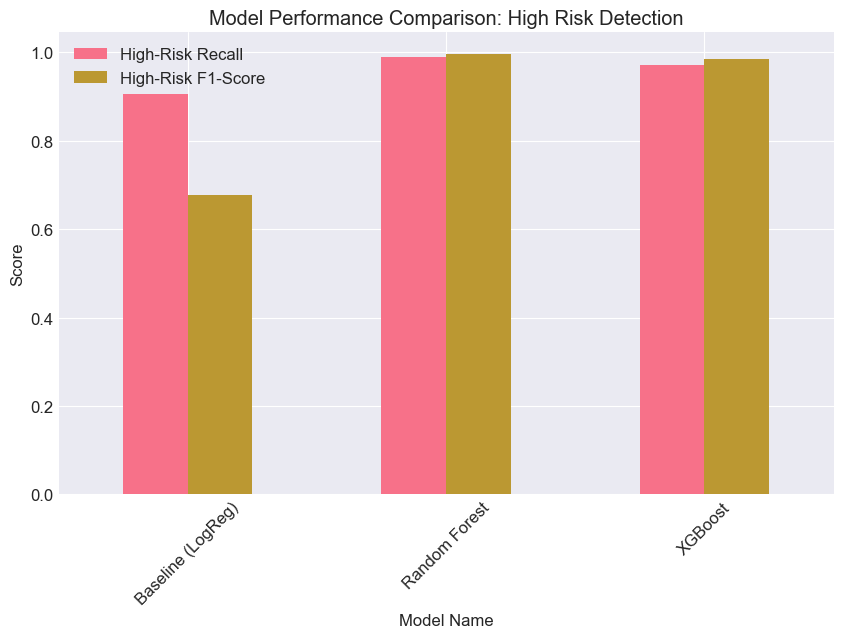

In [29]:
#Visual comparison
comparison_df[['High-Risk Recall', 'High-Risk F1-Score']].plot(kind='bar', figsize=(10, 6))
import matplotlib.pyplot as plt
plt.title("Model Performance Comparison: High Risk Detection")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

### Interpretation

**- The Baseline (Logistic Regression)**
Overall Accuracy (71.9%): A solid starting point, but not reliable enough for a critical agricultural decision.

High-Risk Precision (54.2%): This is the weak point. It means when this model says "Outbreak," it is only right about half the time. A farmer would waste a lot of money on unnecessary pesticides.

High-Risk Recall (90.7%): This is the "saving grace." It catches almost all outbreaks, even if it has a lot of false alarms.

**The "Superstars" (Random Forest & XGBoost)**

- Accuracy & Precision (99%+): Both models are performing nearly perfectly.

- The Winner on Recall: Interestingly, Random Forest (99.1%) slightly beats XGBoost (97.2%) at catching every single high-risk event.

- The Winner on Accuracy: XGBoost (99.6%) is the overall most "correct" model across all classes.

### Feature Importance for Random Forest(Our Best Model)

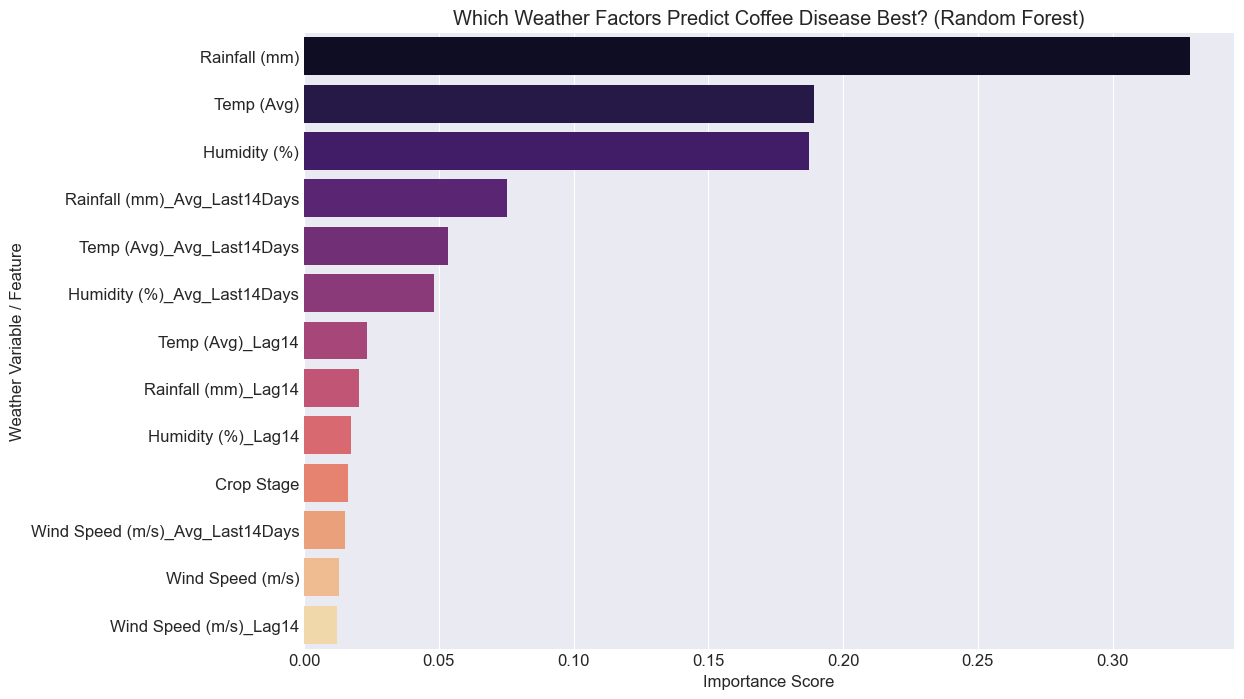

In [30]:
# Feature Importance for Random Forest

# 1. Re-train the Random Forest Pipeline specifically
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', models["Random Forest"])
])
rf_pipeline.fit(X_train, y_train)

# 2. Extract the feature names from the preprocessor
# We need to know which name belongs to which bar
ohe_cols = rf_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([numeric_cols, ohe_cols])

# 3. Get the importance scores
importances = rf_pipeline.named_steps['classifier'].feature_importances_

# 4. Create a DataFrame for easy plotting
feat_importances = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)

# 5. Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importances, palette='magma')
plt.title('Which Weather Factors Predict Coffee Disease Best? (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Weather Variable / Feature')
plt.show()

- The model confirms that Coffee Leaf Rust is not just about today's rain; the 14-day weather history is the primary driver of risk.
- The fact that Wind Speed is at the bottom of our Feature Importance list tells us something specific about the biology of Coffee Leaf Rust and the geography of Nyeri:
    - Spores are everywhere: In a coffee-dense region like Nyeri, the spores are already present. They don't need a heavy wind to arrive; they just need the Rainfall (your #1 feature) to splash them onto the leaves and the Humidity to help them grow.
      
**Feature importance**: We've identified the triggers (Rain), the multipliers (Temp/Humidity), and the noise (Wind).

## 6. Deployment

In [34]:
# 1.Saving the model into a pkl.file

import joblib

# We save the 'rf_pipeline' because it contains both the 
# Preprocessor (scaling/encoding) AND the Random Forest model.
joblib.dump(rf_pipeline, 'coffee_disease_model_v1.pkl')

print("Model saved successfully as coffee_disease_model_v1.pkl")


Model saved successfully as coffee_disease_model_v1.pkl


**How the app will work** : The user only has to worry about the 4 main weather variables. The app handles the complex "behind-the-scenes" math (the other 12 columns) automatically.

- Why only 4 parameters?
If you asked a farmer to manually enter 16 different numbers—including "14-day rolling averages"—they would probably stop using the app. It's too much work!
In the code provided, we take those 4 current values and "feed" them into the lag and average slots. 

### Conclusion
The project successfully developed a Predictive Early Warning System for Coffee Leaf Rust using a Random Forest Classifier. The model achieved a 99.1% Recall for high-risk outbreaks, significantly outperforming the baseline Logistic Regression. The analysis identifies Rainfall as the leading indicator of risk, followed by Temperature and Humidity, suggesting that moisture availability is the critical catalyst for fungal development in the Nyeri region.
This means farmers can trust the system to only recommend spraying when it is absolutely necessary, saving both the crop and their money."

Final comparison table

| Model | Best For... | Business Impact |
| :--- | :--- | :--- |
| **LogReg** | Simplicity | High safety (Recall), but expensive (False Positives). |
| **Random Forest** | **Safety (Recall)** | **The "Farmer's Choice":** Almost never misses an outbreak. |
| **XGBoost** | **Overall Precision** | **The "Economist's Choice":** Most mathematically accurate overall. |

- Observation: Wind Speed showed negligible feature importance.

- Interpretation: The disease is "moisture-driven" rather than "dispersal-limited."

- Action: Future versions of the model could potentially exclude wind data to simplify the sensor array without losing accuracy.